In [109]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal
from scipy.io.wavfile import write

In [135]:
SF = 7 #Spreading Factor
Nsym = 2**SF
f0 = 2**10 # Base frequency
B = 2**10 # Bandwidth
Ts = 1 # Duration of a chirp
SNR = 0.05 # Signal to noise ratio
sn = 32 # Samples per period of highest frequency (>= 2 for nyquist)
fs = sn*(f0+B)*Ts # resolution
t = np.linspace(0, 1, fs) # sampling points
ww = fs*Nsym/B # window function width for short-time-fourier-transform
width, height = 10, 5 # figure sizes

$x(t) = \text{sin} \left[ 2 \pi t \left( \frac k2 t + f_0 \right) \right]$

In [136]:
chirp = lambda f0, k, t: np.sin(2*np.pi*t*(f0 + k*t/2))
stitch = lambda x, c: np.concatenate((x[int(c*len(x)):], x[:int(c*len(x))])) # used for generating symbols from basechirp

In [137]:
butter_lowpass = lambda low, high, fs, order: scipy.signal.butter(order, [2*low/fs, 2*high/fs], btype='band', analog=False)
b, a = butter_lowpass(f0, f0+B, fs, 5)

In [138]:
baseChirp = chirp(f0, B, t)
downChirp = baseChirp[::-1] # inverse Chirp for de-chirping

timingOffsets = np.arange(0, Nsym)/(Nsym) # times where symbols are cut and stitched together
chirps = [stitch(baseChirp, t) for t in timingOffsets]

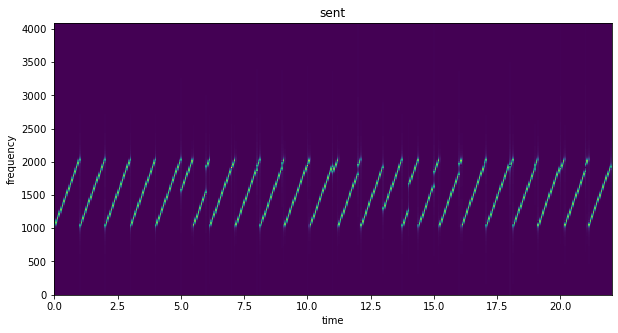

In [139]:
# ASCII-Werte für Nachricht generieren
seq = [ord(char) for char in "Computer Networks"]

# generate and transmit signal
preamble = np.concatenate([baseChirp for i in range(0, 5)]) 
message = np.concatenate([chirps[i] for i in seq])
tx = np.concatenate((preamble, message))
tx_f, tx_t, tx_Zxx = scipy.signal.stft(tx, fs, nperseg=ww)
frequencyRangeOfInterest = 4*len(tx_f)//sn

plt.figure(figsize=(width, height))
plt.title("sent")
plt.xlabel("time")
plt.ylabel("frequency")
plt.pcolormesh(tx_t, tx_f[:frequencyRangeOfInterest], np.abs(tx_Zxx[:frequencyRangeOfInterest]))
plt.savefig("sent.png")

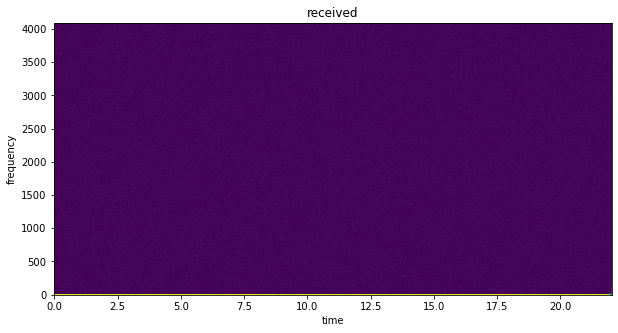

In [140]:
# Simulate signal manipulation during travel
noise = np.random.normal(-1/SNR, 1/SNR, len(tx))
rx = tx + noise
rx_f, rx_t, rx_Zxx = scipy.signal.stft(rx, fs, nperseg=ww)
frequencyRangeOfInterest = 4*len(tx_f)//sn

plt.figure(figsize=(width, height))
plt.title("received")
plt.xlabel("time")
plt.ylabel("frequency")
plt.pcolormesh(rx_t, rx_f[:frequencyRangeOfInterest], np.abs(rx_Zxx[:frequencyRangeOfInterest]))
plt.savefig("received.png")

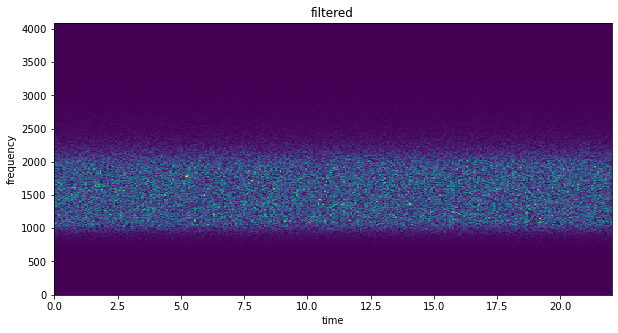

In [141]:
#demodulation preparation
lowpass = scipy.signal.lfilter(b, a, rx)
lp_f, lp_t, lp_Zxx = scipy.signal.stft(lowpass, fs, nperseg=ww)
frequencyRangeOfInterest = 4*len(tx_f)//sn

plt.figure(figsize=(width, height))
plt.title("filtered")
plt.xlabel("time")
plt.ylabel("frequency")
plt.pcolormesh(lp_t, lp_f[:frequencyRangeOfInterest], np.abs(lp_Zxx[:frequencyRangeOfInterest]))
plt.savefig("filtered.png")

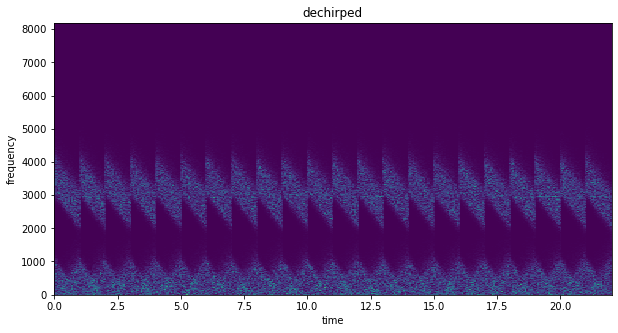

In [142]:
#dechirp
dechirped = lowpass * np.ndarray.flatten(np.repeat(np.array([downChirp]), len(tx)/fs, 0))
dc_f, dc_t, dc_Zxx = scipy.signal.stft(dechirped, fs, nperseg=ww)
frequencyRangeOfInterest = 8*len(tx_f)//sn

plt.figure(figsize=(width, height))
plt.title("dechirped")
plt.xlabel("time")
plt.ylabel("frequency")
plt.pcolormesh(dc_t, dc_f[:frequencyRangeOfInterest], np.abs(dc_Zxx[:frequencyRangeOfInterest]))
plt.savefig("dechirped.png")

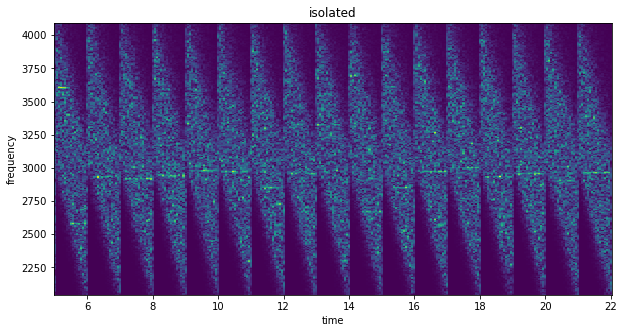

In [143]:
#remove preamble and excess frequencies
sx = int(2*len(preamble)//ww)
sy = np.argmin(np.abs(dc_f-2*(f0)))
ey = np.argmin(np.abs(dc_f-2*(f0+B)))
is_t = dc_t[sx:]
is_f = dc_f[sy:ey]
is_Zxx = dc_Zxx[sy:ey,sx:]

plt.figure(figsize=(width, height))
plt.title("isolated")
plt.xlabel("time")
plt.ylabel("frequency")
plt.pcolormesh(is_t, is_f, np.abs(is_Zxx))
plt.savefig("isolated.png")

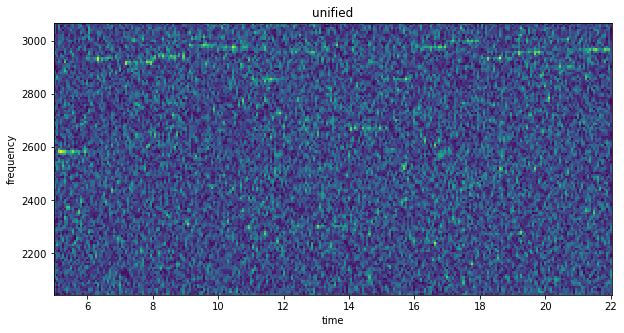

In [144]:
#unify low- and high-pitch parts of chirps.
un_t = is_t
un_f = is_f[:len(is_f)//2]
un_Zxx = np.add(is_Zxx[:len(un_f)], is_Zxx[len(un_f):2*len(un_f)])

plt.figure(figsize=(width, height))
plt.title("unified")
plt.xlabel("time")
plt.ylabel("frequency")
plt.pcolormesh(un_t, un_f, np.abs(un_Zxx))
plt.savefig("unified.png")

Computer Networks


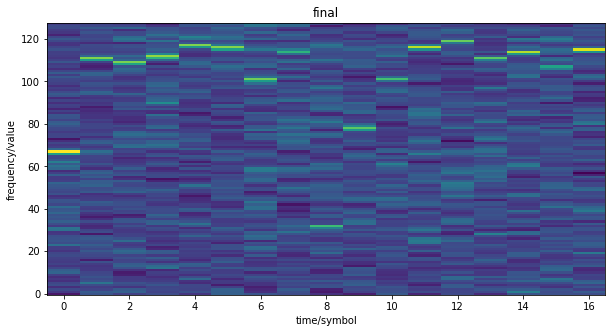

In [145]:
# seperate transmission into symbols
samplesPerSymbol = len(is_t)//len(seq)
splits = np.array([i*samplesPerSymbol for i in range(1, len(seq)+1)])
sy_t = splits
sy_f = un_f
sy_Zxx = np.split(un_Zxx, splits, axis=1)[:-1]

#sum over time
fin_t = np.arange(0, len(sy_t))
fin_f = np.arange(0, len(sy_f))
fin_Zxx = np.sum(np.abs(sy_Zxx), axis=2)
peaks = np.argmax(fin_Zxx, axis=1)

read = str(''.join(map(chr, peaks)))
print(read)

plt.figure(figsize=(width, height))
plt.title("final")
plt.xlabel("time/symbol")
plt.ylabel("frequency/value")
plt.pcolormesh(fin_t, fin_f, np.transpose(fin_Zxx))
plt.savefig("final.png")

In [147]:
# generate Audio
rate = fs
data = tx
scaled = np.int16(data / np.max(np.abs(data)) * 32767)
write('tx.wav', rate, scaled)

data = rx
scaled = np.int16(data / np.max(np.abs(data)) * 32767)
write('rx.wav', rate, scaled)